In [1]:
# Mounting colab on drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
# Enter the folder name
FOLDER_NAME = '/content/drive/My Drive/Project/'
DATA = '/content/drive/My Drive/Project/labeled_data.csv'

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import openpyxl
import xlrd

In [3]:
df=pd.read_csv(DATA)
# df=df.drop(df.index[1460:])
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# Creating model for finding relvant reviews

In [4]:
df_New = df[["class", "tweet"]]

In [5]:
df_New.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
df_new = df_New.fillna(value = -1)

# df_new["class"] += 1

In [7]:
df_new.head(20)

# 0 - Irrelevant
# 1 - Potential Shift
# 2 - Actual Shift

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,1,""" &amp; you might not get ya bitch back &amp; ..."
9,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [8]:
!pip install transformers
!pip install emoji
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 10.8 MB/s eta 0:00:00


In [9]:
!pip3 install keras_preprocessing

from keras_preprocessing.sequence import pad_sequences

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [10]:
import torch
import json
import random
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
from transformers import *
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
#from transformers import LongformerTokenizer, LongformerForSequenceClassification
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *


# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name())

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v4.40. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v4.40. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` fr

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [11]:
from collections import Counter

def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)


def preprocess_sent(sent):
    sent = re.sub(r"http\S+", "", sent)
    sent = re.sub(r"@\S+", "@user", sent)

    # print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    return sent

def evalMetric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    return {"accuracy": accuracy, 'mF1Score': mf1Score, 'f1Score': f1Score, 'auc': area_under_c,
            'precision': precisionScore, 'recall': recallScore}


#Creating an attention mask - For actual tokens its set to 1, for padding tokens its set to 0
def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)

def getFeaturesandLabel(X,y):
    sentences = list(X)
    sentences = ["[CLS] "+ preprocess_sent(i) + " [SEP]"for i in sentences]
    tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:512], tqdm(sentences)))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenizer_texts)]
    input_ids = pad_sequences(sequences = input_ids, maxlen = param['maxLen'], dtype = 'long', padding='post', truncating='post')
    attention_masks_data = create_attention_masks(input_ids)
    X_data = torch.tensor(input_ids)
    attention_masks_data = torch.tensor(attention_masks_data)
    y_data = torch.tensor(y)
    return X_data, attention_masks_data, y_data


def flat_accuracy(preds, labels):
    labels_flat = labels
    return len([i for i in range(len(preds)) if preds[i] == labels_flat[i]]) / len(labels_flat)


def flat_mF1(preds, labels):
    labels_flat = labels
    return f1_score(labels_flat, preds, average='macro', zero_division=0)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training the classifier 1

In [12]:
df_new["class"].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [13]:
counts = [19190, 4163, 1430]
weights = []
for cnt in counts:
    weights.append(sum(counts)/cnt)
x = sum(weights)
weights = [y/x for y in weights]
weights

[0.052550714689507914, 0.2422407434282145, 0.7052085418822776]

In [14]:
param ={
    'maxLen' :256,
    'weights':weights
}

In [15]:
import torch
import torch.nn as nn
# Class for weighted bert for sentence classification
class SC_weighted_BERT(BertPreTrainedModel):
    def __init__(self, config,weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.weights=weights
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[8:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(self.weights).cuda())
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_new, test_size=0.2, random_state = 2023)

X_tn = list(train["tweet"])
y_tn = list(train["class"])
X_ts = list(test["tweet"])
y_ts = list(test["class"])

In [18]:
y_tn = [int(y) for y in y_tn]
y_ts = [int(y) for y in y_ts]

In [19]:
X_train, attention_masks_train, y_train = getFeaturesandLabel(X_tn,y_tn)
X_test, attention_masks_test, y_test = getFeaturesandLabel(X_ts,y_ts)

100%|██████████| 4957/4957 [00:00<00:00, 11233.25it/s]


In [20]:
BATCH_SIZE = 16
#Dataset wrapping tensors.
train_data = TensorDataset(X_train, attention_masks_train, y_train)
test_data = TensorDataset(X_test, attention_masks_test, y_test)

#Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
train_sampler = RandomSampler(train_data)
test_sampler = SequentialSampler(test_data)

#represents a Python iterable over a dataset
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = BATCH_SIZE)

In [21]:
torch.cuda.empty_cache()

In [22]:
import numpy as np
def getProb(temp):
    t = np.exp(temp)
    return t[1]/(sum(t))

In [23]:
def getPerformanceOfLoader(test_dataloader):
    model.eval()
    # Tracking variables
    predictions , true_labels = [], []
    # Predict
    for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        predictions.extend(logits)
        true_labels.extend(label_ids)

    print('DONE.')
    predict =[np.argmax(np.array(pre)) for pre in predictions]
    proba = [pre[np.argmax(np.array(pre))] for pre in predictions]


    df = pd.DataFrame()
    df['target'] = predict
    df['score'] = proba
    return df

In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()

bestValmF1  = 0
besttest_df  = None
bestModel = None
ModelPath = FOLDER_NAME + "Models"

# linear classification layer on top.
model = SC_weighted_BERT.from_pretrained(
        'bert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 3, # The number of output labels--2 for binary classification             # You can increase this for multi-class tasks.
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        weights=weights
)

# Tell pytorch to run this model on the GPU.
model = model.to(device)

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 5
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 20 == 0 and not step==0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_mF1 = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    logitsVal = []
    labelsVal = []

    # Evaluate data for one epoch
    for batch in test_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        logitsVal += list(np.argmax(logits, axis=1).flatten())
        labelsVal += list(label_ids.flatten())

        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    eval_mF1 = flat_accuracy(logitsVal, labelsVal)
    if ((eval_mF1) > bestValmF1):
         bestValmF1  = eval_mF1
         model.save_pretrained(ModelPath)
         tokenizer.save_pretrained(ModelPath)
         besttest_df = getPerformanceOfLoader(test_dataloader)
    # Report the final accuracy for this validation run.
    print("  Macro F1 score: {0:.2f}".format(eval_mF1))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Some weights of the model checkpoint at bert-base-uncased were not used when initializing SC_weighted_BERT: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing SC_weighted_BERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SC_weighted_BERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification


======== Epoch 1 / 5 ========
Training...
  Batch    20  of  1,240.    Elapsed: 0:00:14.
  Batch    40  of  1,240.    Elapsed: 0:00:26.
  Batch    60  of  1,240.    Elapsed: 0:00:39.
  Batch    80  of  1,240.    Elapsed: 0:00:52.
  Batch   100  of  1,240.    Elapsed: 0:01:05.
  Batch   120  of  1,240.    Elapsed: 0:01:18.
  Batch   140  of  1,240.    Elapsed: 0:01:32.
  Batch   160  of  1,240.    Elapsed: 0:01:45.
  Batch   180  of  1,240.    Elapsed: 0:01:58.
  Batch   200  of  1,240.    Elapsed: 0:02:11.
  Batch   220  of  1,240.    Elapsed: 0:02:24.
  Batch   240  of  1,240.    Elapsed: 0:02:37.
  Batch   260  of  1,240.    Elapsed: 0:02:51.
  Batch   280  of  1,240.    Elapsed: 0:03:04.
  Batch   300  of  1,240.    Elapsed: 0:03:17.
  Batch   320  of  1,240.    Elapsed: 0:03:30.
  Batch   340  of  1,240.    Elapsed: 0:03:43.
  Batch   360  of  1,240.    Elapsed: 0:03:56.
  Batch   380  of  1,240.    Elapsed: 0:04:09.
  Batch   400  of  1,240.    Elapsed: 0:04:23.
  Batch   420  of

Configuration saved in /content/drive/My Drive/Project/Models/config.json
Model weights saved in /content/drive/My Drive/Project/Models/model.safetensors
tokenizer config file saved in /content/drive/My Drive/Project/Models/tokenizer_config.json
Special tokens file saved in /content/drive/My Drive/Project/Models/special_tokens_map.json


DONE.
  Macro F1 score: 0.91
  Validation took: 0:02:32

======== Epoch 2 / 5 ========
Training...
  Batch    20  of  1,240.    Elapsed: 0:00:13.
  Batch    40  of  1,240.    Elapsed: 0:00:26.
  Batch    60  of  1,240.    Elapsed: 0:00:39.
  Batch    80  of  1,240.    Elapsed: 0:00:53.
  Batch   100  of  1,240.    Elapsed: 0:01:06.
  Batch   120  of  1,240.    Elapsed: 0:01:19.
  Batch   140  of  1,240.    Elapsed: 0:01:32.
  Batch   160  of  1,240.    Elapsed: 0:01:45.
  Batch   180  of  1,240.    Elapsed: 0:01:58.
  Batch   200  of  1,240.    Elapsed: 0:02:11.
  Batch   220  of  1,240.    Elapsed: 0:02:25.
  Batch   240  of  1,240.    Elapsed: 0:02:38.
  Batch   260  of  1,240.    Elapsed: 0:02:51.
  Batch   280  of  1,240.    Elapsed: 0:03:04.
  Batch   300  of  1,240.    Elapsed: 0:03:17.
  Batch   320  of  1,240.    Elapsed: 0:03:30.
  Batch   340  of  1,240.    Elapsed: 0:03:43.
  Batch   360  of  1,240.    Elapsed: 0:03:57.
  Batch   380  of  1,240.    Elapsed: 0:04:10.
  Batch 

Configuration saved in /content/drive/My Drive/Project/Models/config.json
Model weights saved in /content/drive/My Drive/Project/Models/model.safetensors
tokenizer config file saved in /content/drive/My Drive/Project/Models/tokenizer_config.json
Special tokens file saved in /content/drive/My Drive/Project/Models/special_tokens_map.json


DONE.
  Macro F1 score: 0.91
  Validation took: 0:02:28

======== Epoch 3 / 5 ========
Training...
  Batch    20  of  1,240.    Elapsed: 0:00:13.
  Batch    40  of  1,240.    Elapsed: 0:00:26.
  Batch    60  of  1,240.    Elapsed: 0:00:39.
  Batch    80  of  1,240.    Elapsed: 0:00:53.
  Batch   100  of  1,240.    Elapsed: 0:01:06.
  Batch   120  of  1,240.    Elapsed: 0:01:19.
  Batch   140  of  1,240.    Elapsed: 0:01:32.
  Batch   160  of  1,240.    Elapsed: 0:01:45.
  Batch   180  of  1,240.    Elapsed: 0:01:58.
  Batch   200  of  1,240.    Elapsed: 0:02:11.
  Batch   220  of  1,240.    Elapsed: 0:02:25.
  Batch   240  of  1,240.    Elapsed: 0:02:38.
  Batch   260  of  1,240.    Elapsed: 0:02:51.
  Batch   280  of  1,240.    Elapsed: 0:03:04.
  Batch   300  of  1,240.    Elapsed: 0:03:17.
  Batch   320  of  1,240.    Elapsed: 0:03:30.
  Batch   340  of  1,240.    Elapsed: 0:03:44.
  Batch   360  of  1,240.    Elapsed: 0:03:57.
  Batch   380  of  1,240.    Elapsed: 0:04:10.
  Batch 

Configuration saved in /content/drive/My Drive/Project/Models/config.json
Model weights saved in /content/drive/My Drive/Project/Models/model.safetensors
tokenizer config file saved in /content/drive/My Drive/Project/Models/tokenizer_config.json
Special tokens file saved in /content/drive/My Drive/Project/Models/special_tokens_map.json


DONE.
  Macro F1 score: 0.91
  Validation took: 0:02:27

======== Epoch 5 / 5 ========
Training...
  Batch    20  of  1,240.    Elapsed: 0:00:13.
  Batch    40  of  1,240.    Elapsed: 0:00:26.
  Batch    60  of  1,240.    Elapsed: 0:00:39.
  Batch    80  of  1,240.    Elapsed: 0:00:53.
  Batch   100  of  1,240.    Elapsed: 0:01:06.
  Batch   120  of  1,240.    Elapsed: 0:01:19.
  Batch   140  of  1,240.    Elapsed: 0:01:32.
  Batch   160  of  1,240.    Elapsed: 0:01:45.
  Batch   180  of  1,240.    Elapsed: 0:01:59.
  Batch   200  of  1,240.    Elapsed: 0:02:12.
  Batch   220  of  1,240.    Elapsed: 0:02:25.
  Batch   240  of  1,240.    Elapsed: 0:02:38.
  Batch   260  of  1,240.    Elapsed: 0:02:51.
  Batch   280  of  1,240.    Elapsed: 0:03:04.
  Batch   300  of  1,240.    Elapsed: 0:03:17.
  Batch   320  of  1,240.    Elapsed: 0:03:31.
  Batch   340  of  1,240.    Elapsed: 0:03:44.
  Batch   360  of  1,240.    Elapsed: 0:03:57.
  Batch   380  of  1,240.    Elapsed: 0:04:10.
  Batch 

In [25]:
print(classification_report(y_ts, list(besttest_df['target'])))

              precision    recall  f1-score   support

           0       0.58      0.30      0.39       299
           1       0.93      0.96      0.95      3844
           2       0.86      0.89      0.88       814

    accuracy                           0.91      4957
   macro avg       0.79      0.72      0.74      4957
weighted avg       0.90      0.91      0.90      4957



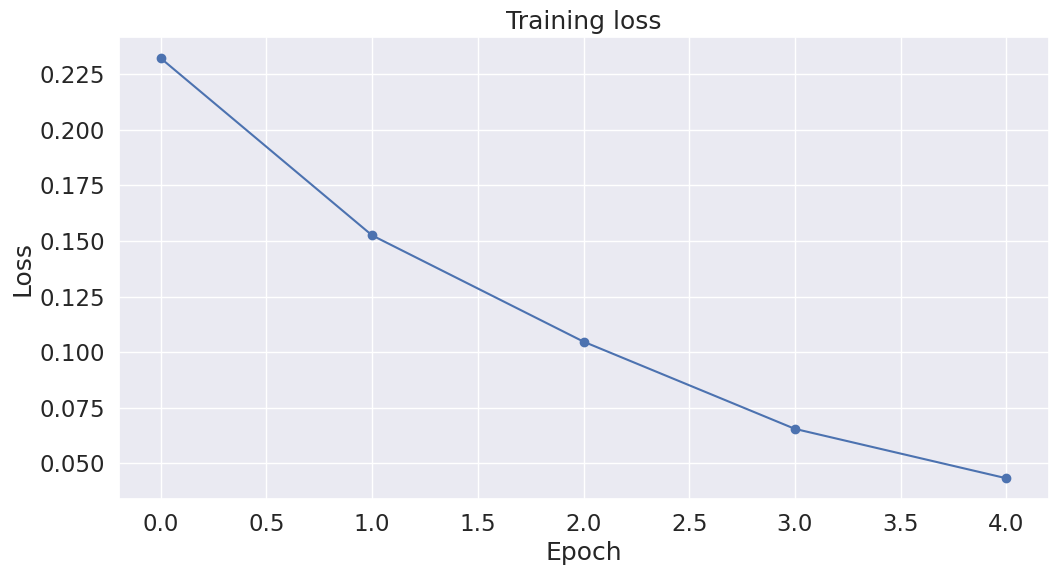

In [26]:
import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()